In [1]:
# %%
# --- Core Imports ---
import os
import sys
import logging
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

from utils.grid_utils import *
from utils.model_utils import *


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


2025-09-13 20:11:30,254 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-13 20:11:30,418 - INFO - Model loaded successfully to cuda.


Working directory changed to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS
Configuration Initialized. Using Device: cuda

RUNNING COMBINED ANALYSIS: Accuracy & Bias vs. Context Length
Correctly identified direction token IDs: {'NORTH': 276, 'SOUTH': 272, 'EAST': 282, 'WEST': 279}


Evaluating across context lengths: 100%|██████████| 26/26 [03:22<00:00,  7.80s/it]


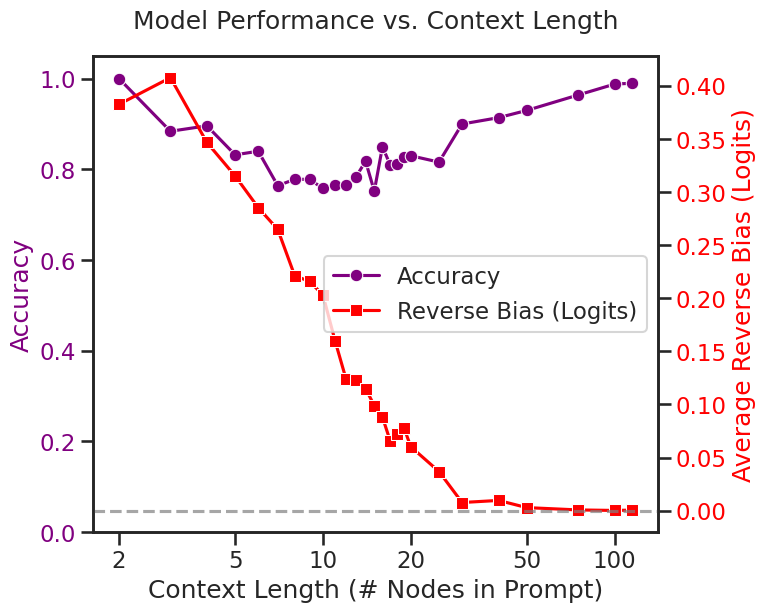


Analysis Summary:
 Context Length  Accuracy  Average Reverse Bias
              2     1.000              0.382421
              3     0.884              0.407510
              4     0.896              0.346557
              5     0.832              0.314963
              6     0.840              0.285192
              7     0.764              0.264628
              8     0.778              0.221202
              9     0.778              0.215664
             10     0.758              0.203070
             11     0.766              0.160005
             12     0.766              0.123903
             13     0.784              0.123331
             14     0.818              0.114870
             15     0.752              0.098805
             16     0.850              0.087945
             17     0.810              0.065757
             18     0.812              0.072353
             19     0.828              0.077326
             20     0.830              0.060183
             25     0

In [ ]:
# %%
# --- Core Imports and Setup ---
import os
import gc
import logging
import random
import re
import string
from tqdm import tqdm

import networkx as nx
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

sns.set_theme(
    style="whitegrid",
    palette="colorblind",
    font_scale=1.2,
    rc={
        "axes.labelsize": 14,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (8, 6)
    }
)

sns.set_theme(style="ticks", context="talk")

try:
    os.chdir("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS")
    print(f"Working directory changed to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Warning: Could not change directory. Using current directory: {os.getcwd()}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = '/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000'
# Alternative model path from your examples:
# MODEL_PATH = '/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_2/checkpoint-65000'

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed=42):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
print(f"Configuration Initialized. Using Device: {DEVICE}")


DIRECTIONS_NSWE = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
REVERSE_DIRECTIONS = {'NORTH': 'SOUTH', 'SOUTH': 'NORTH', 'EAST': 'WEST', 'WEST': 'EAST'}

def generate_grid_graph(size=4, direction_map=None):
    if direction_map is None:
        direction_map = DIRECTIONS_NSWE
    G = nx.DiGraph()
    nodes = [f"{chr(97+i)}{chr(97+j)}" for i in range(size) for j in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction=direction_map['E'])
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction=direction_map['W'])
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction=direction_map['S'])
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction=direction_map['N'])
    return G, nodes, {}

def generate_random_walk(G, start_node, length):
    path = [start_node]
    current_node = start_node
    for _ in range(length - 1):
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

def walk_to_string(walk, G):
    if not walk: return ""
    if len(walk) == 1: return walk[0]
    parts = [f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)]
    parts.append(walk[-1])
    return " ".join(parts)

def create_foraging_tasks(G, nodes, n_tasks, context_length, **kwargs):
    test_cases = []
    for i in range(n_tasks):
        random_walk_start = random.choice(nodes)
        random_walk_context = generate_random_walk(G, random_walk_start, length=context_length)
        task_info = {
            'name': f'Task {i+1}', 'graph': G, 'task_type': 'foraging',
            'random_walk_context': random_walk_context, 'start': random_walk_context[-1],
            **kwargs
        }
        test_cases.append(task_info)
    return test_cases


class ForagingPromptStrategy(ABC):
    @abstractmethod
    def create_prompt(self, task: dict) -> str:
        pass

class InContextStyleForagingStrategy(ForagingPromptStrategy):
    def create_prompt(self, task: dict) -> str:
        return walk_to_string(task['random_walk_context'], task['graph'])

class NavigationGPT:
    """A wrapper for loading and running the navigation model."""
    def __init__(self, model_path: str):
        logging.info(f"Loading model and tokenizer from: {model_path}")
        if not os.path.isdir(model_path):
            raise FileNotFoundError(f"Model path does not exist: {model_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()
        logging.info(f"Model loaded successfully to {DEVICE}.")

    def generate_path(self, prompt: str, max_new_tokens: int = 60):
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(
                **encodings, max_new_tokens=max_new_tokens, num_beams=1,
                pad_token_id=self.tokenizer.eos_token_id
            )
        prompt_len = encodings.input_ids.shape[1]
        return self.tokenizer.decode(output_ids[0, prompt_len:], skip_special_tokens=False).strip()

def get_next_step_logits(prompt: str, model: GPT2LMHeadModel, tokenizer: GPT2TokenizerFast) -> torch.Tensor:
    """Given a prompt, returns the logits for the next token prediction."""
    encodings = tokenizer(prompt, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        outputs = model(**encodings)
        next_token_logits = outputs.logits[0, -1, :]
    return next_token_logits

def parse_path_with_directions(generated_text: str) -> list[tuple[str, str]]:
    """Robustly parse direction-node pairs from the model's output."""
    pattern = re.compile(r'\b(NORTH|SOUTH|EAST|WEST)\b\s+\b([a-z]{2})\b')
    return pattern.findall(generated_text)


def run_accuracy_evaluation(model: NavigationGPT, test_cases: list, prompt_strategy: ForagingPromptStrategy):
    """Runs evaluation for single-step path generation accuracy. (This function is fine as-is)"""
    results = []
    for task in test_cases:
        prompt = prompt_strategy.create_prompt(task)
        # Generate just enough tokens for one step (e.g., "DIRECTION NODE")
        generated_text = model.generate_path(prompt, max_new_tokens=5)
        parsed_steps = parse_path_with_directions(generated_text)

        is_path_valid = False
        if parsed_steps:
            direction, next_node = parsed_steps[0]
            current_node = task['start']
            graph = task['graph']
            if graph.has_edge(current_node, next_node):
                correct_direction = graph.edges[current_node, next_node]['direction']
                if direction == correct_direction:
                    is_path_valid = True

        results.append({'accuracy': 1.0 if is_path_valid else 0.0})
    return pd.DataFrame(results)

def run_reverse_bias_evaluation(model: NavigationGPT, test_cases: list, direction_token_ids: dict):
    """
    Calculates the model's bias towards reversing its last direction using LOGITS.
    This version is corrected to use the proper tokenization and logit-based metric.
    """
    biases = []
    for task in test_cases:
        walk = task['random_walk_context']
        if len(walk) < 2:
            continue # Cannot calculate bias without a previous step

        graph = task['graph']
        current_node = walk[-1]
        previous_node = walk[-2]

        # Determine the reverse direction based on the graph edge
        reverse_direction = graph.edges[current_node, previous_node]['direction']
        
        # The prompt should be the full walk history. The model predicts what comes after the last node.
        prompt = walk_to_string(walk, graph)
        logits = get_next_step_logits(prompt, model.model, model.tokenizer)
        
        # Get the logit for the reverse direction using the pre-calculated token ID
        reverse_token_id = direction_token_ids[reverse_direction]
        logit_reverse = logits[reverse_token_id].item()

        # Get logits for all other valid forward directions
        other_valid_directions = [
            graph.edges[current_node, neighbor]['direction']
            for neighbor in graph.successors(current_node)
            if neighbor != previous_node
        ]
        
        if not other_valid_directions:
            biases.append(np.nan) # Bias is undefined if the only way out is backwards
            continue
            
        logits_other = [
            logits[direction_token_ids[direction]].item()
            for direction in other_valid_directions
        ]
        
        mean_logit_other = np.mean(logits_other)
        
        bias = logit_reverse - mean_logit_other
        biases.append(bias)

    return np.nanmean(biases) if biases else 0.0


ANALYSIS_GRID_SIZE = 4
CONTEXT_LENGTHS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 40, 50, 75, 100, 115]
N_TESTS_PER_POINT = 500
PROMPT_STRATEGY = InContextStyleForagingStrategy()

all_results = []
if os.path.isdir(MODEL_PATH):
    try:
        model = NavigationGPT(MODEL_PATH)

        direction_token_ids = {
            direction: model.tokenizer.encode(" " + direction, add_special_tokens=False)[0]
            for direction in DIRECTIONS_NSWE.values()
        }
        print(f"Correctly identified direction token IDs: {direction_token_ids}")


        for context_len in tqdm(CONTEXT_LENGTHS, desc="Evaluating across context lengths"):
            G, nodes, _ = generate_grid_graph(size=ANALYSIS_GRID_SIZE, direction_map=DIRECTIONS_NSWE)
            test_cases = create_foraging_tasks(G, nodes, n_tasks=N_TESTS_PER_POINT, context_length=context_len)

            accuracy_df = run_accuracy_evaluation(model, test_cases, PROMPT_STRATEGY)
            accuracy = accuracy_df['accuracy'].mean()

            avg_bias = run_reverse_bias_evaluation(model, test_cases, direction_token_ids)

            all_results.append({
                "Context Length": context_len,
                "Accuracy": accuracy,
                "Average Reverse Bias": avg_bias
            })

        del model; gc.collect(); torch.cuda.empty_cache()

    except Exception as e:
        logging.error(f"An error occurred during evaluation: {e}", exc_info=True)

if all_results:
    results_df = pd.DataFrame(all_results)
    
    fig, ax1 = plt.subplots()
    color_accuracy = 'purple'
    color_bias = 'red'

    sns.lineplot(data=results_df, x='Context Length', y='Accuracy',
                 marker='o', ax=ax1, color=color_accuracy, label='Accuracy')
    ax1.set_xlabel('Context Length (# Nodes in Prompt)')
    ax1.set_ylabel('Accuracy', color=color_accuracy)
    ax1.tick_params(axis='y', labelcolor=color_accuracy)
    ax1.set_xscale('log')
    ax1.set_ylim(0, 1.05)

    ax2 = ax1.twinx()
    sns.lineplot(data=results_df, x='Context Length', y='Average Reverse Bias',
                 marker='s', ax=ax2, color=color_bias, label='Reverse Bias (Logits)')
    ax2.set_ylabel('Average Reverse Bias (Logits)', color=color_bias)
    ax2.tick_params(axis='y', labelcolor=color_bias)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    if ax1.get_legend() is not None: ax1.get_legend().remove()
    if ax2.get_legend() is not None: ax2.get_legend().remove()

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    
    x_ticks_to_show = [2, 5, 10, 20, 50, 100]
    ax1.set_xticks(x_ticks_to_show)
    ax1.set_xticklabels([str(t) for t in x_ticks_to_show])
    ax1.minorticks_off()

    fig.tight_layout()
    plt.title("Model Performance vs. Context Length", pad=20)
    plt.show()

    print("\nAnalysis Summary:")
    print(results_df.to_string(index=False))
else:
    logging.warning(f"SKIPPING Analysis: Model path not found or evaluation failed: {MODEL_PATH}")

print("\nAnalysis complete.")

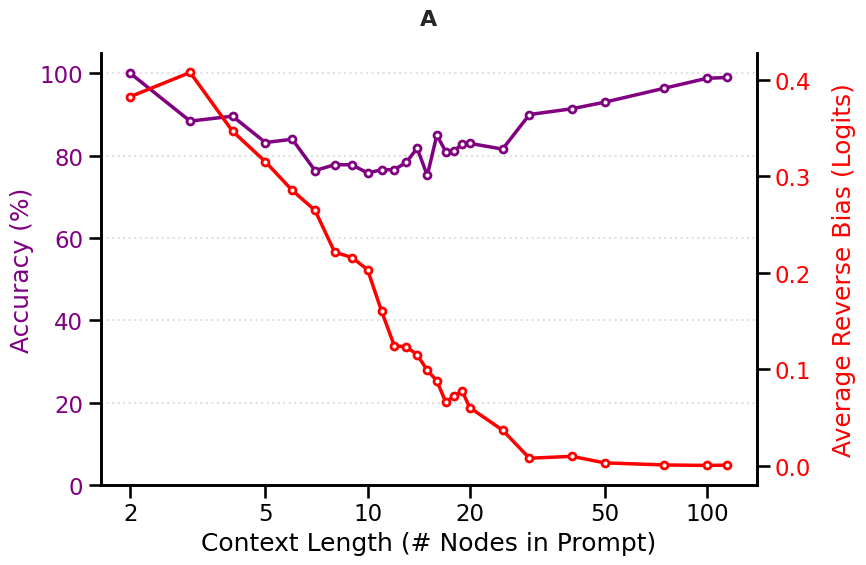


Analysis Summary:
 Context Length  Accuracy  Average Reverse Bias
              2     1.000              0.382421
              3     0.884              0.407510
              4     0.896              0.346557
              5     0.832              0.314963
              6     0.840              0.285192
              7     0.764              0.264628
              8     0.778              0.221202
              9     0.778              0.215664
             10     0.758              0.203070
             11     0.766              0.160005
             12     0.766              0.123903
             13     0.784              0.123331
             14     0.818              0.114870
             15     0.752              0.098805
             16     0.850              0.087945
             17     0.810              0.065757
             18     0.812              0.072353
             19     0.828              0.077326
             20     0.830              0.060183
             25     0

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker


if all_results:
    results_df = pd.DataFrame(all_results)
    plt.rcParams.update({
        'axes.linewidth': 2,
        'xtick.major.width': 2,
        'ytick.major.width': 2,
        'xtick.major.size': 7,
        'ytick.major.size': 7,
    })

    plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 2,
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelcolor": "black",
    "xtick.major.width": 2,
    "ytick.major.width": 2,
    "xtick.major.size": 7,
    "ytick.major.size": 7,
    })

    sns.set_theme(style="ticks", context="talk", rc={
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})


    fig, ax1 = plt.subplots(figsize=(9, 6))


    color_accuracy = 'purple'
    color_bias = 'red'


    ax1.plot(
        results_df['Context Length'], results_df['Accuracy'],
        linestyle='-', color=color_accuracy, linewidth=2.5,
        marker='o', markersize=5,
        markerfacecolor='white', markeredgecolor=color_accuracy, markeredgewidth=2,
        label="Accuracy"
    )
    ax1.set_xlabel('Context Length (# Nodes in Prompt)', color='black')
    ax1.set_ylabel('Accuracy (%)', color=color_accuracy)
    ax1.tick_params(axis='y', labelcolor=color_accuracy)
    ax1.set_xscale('log')
    ax1.set_ylim(0, 1.05)
    ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, symbol=None))


    ax2 = ax1.twinx()
    ax2.plot(
        results_df['Context Length'], results_df['Average Reverse Bias'],
        linestyle='-', color=color_bias, linewidth=2.5,
        marker='o', markersize=5,
        markerfacecolor='white', markeredgecolor=color_bias, markeredgewidth=2,
        label="Reverse Bias (Logits)"
    )
    ax2.set_ylabel('Average Reverse Bias (Logits)', color=color_bias,labelpad=15)
    ax2.tick_params(axis='y', labelcolor=color_bias)
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

    x_ticks_to_show = [2, 5, 10, 20, 50, 100]
    ax1.set_xticks(x_ticks_to_show)
    ax1.set_xticklabels([str(t) for t in x_ticks_to_show])
    ax1.minorticks_off()

    if ax1.get_legend(): ax1.get_legend().remove()
    if ax2.get_legend(): ax2.get_legend().remove()

    ax1.yaxis.grid(True, linestyle=':', color='lightgray', alpha=0.7)
    sns.despine(right=False)

    plt.title("A", pad=20, fontsize=16, fontweight='bold')
    fig.tight_layout()
    plt.show()

    plt.rcParams.update(plt.rcParamsDefault)

    print("\nAnalysis Summary:")
    print(results_df.to_string(index=False))
else:
    logging.warning("SKIPPING Analysis: Model path not found or evaluation failed.")

print("\nAnalysis complete.")
